In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
df_05 = pd.read_csv('data/merged-05-2019.csv')
df_06 = pd.read_csv('data/merged-06-2019.csv')
df_07 = pd.read_csv('data/merged-07-2019.csv')
df_08 = pd.read_csv('data/merged-08-2019.csv')

In [3]:
df = pd.concat([df_05, df_06, df_07, df_08], ignore_index=True)
#, df_08, df_09, df_10, df_11, df_12

In [4]:
%reset_selective -f "^df_"

In [5]:
df = df[['carrier_code', 'day', 'weekday', 'month', 'origin_airport', 'destination_airport', 
          'scheduled_elapsed_time', 'scheduled_departure_dt', 'scheduled_arrival_dt',
          'STATION_x', 'HourlyDryBulbTemperature_x', 'HourlyPrecipitation_x', 'HourlyVisibility_x', 'HourlyWindSpeed_x',
          'STATION_y', 'HourlyDryBulbTemperature_y', 'HourlyPrecipitation_y', 'HourlyVisibility_y', 'HourlyWindSpeed_y',
          'arrival_delay', 'cancelled_code']]
# drop unknown data 
df = df.dropna(subset=['STATION_x', 'STATION_y'])

# datetime to minutes from midnight
# scheduled departure
df['scheduled_departure_dt'] = pd.to_datetime(df['scheduled_departure_dt']).dt.hour * 60 + pd.to_datetime(df['scheduled_departure_dt']).dt.minute
minutes_in_day = 24*60
df['sin_scheduled_departure'] = np.sin(2*np.pi*df['scheduled_departure_dt']/minutes_in_day)
df['cos_scheduled_departure'] = np.cos(2*np.pi*df['scheduled_departure_dt']/minutes_in_day)
# scheduled arrival
df['scheduled_arrival_dt'] = pd.to_datetime(df['scheduled_arrival_dt']).dt.hour * 60 + pd.to_datetime(df['scheduled_arrival_dt']).dt.minute
minutes_in_day = 24*60
df['sin_scheduled_arrival'] = np.sin(2*np.pi*df['scheduled_arrival_dt']/minutes_in_day)
df['cos_scheduled_arrival'] = np.cos(2*np.pi*df['scheduled_arrival_dt']/minutes_in_day)

# construct output
# 0 - cancelled flights
# 1 - delayed flights
# 2 - on time
def make_binary_output(row):
    if row['cancelled_code'] != 'N' or row['arrival_delay'] > 30:
      return 1
    return 0
def make_multi_output(row):
    if row['cancelled_code'] != 'N':
      return 2
    if row['arrival_delay'] > 30:
      return 1
    return 0
df['output'] = df.apply(make_multi_output, axis=1)

# drop extra columns
df = df.drop(columns=['cancelled_code', 'arrival_delay', 'scheduled_departure_dt', 'scheduled_arrival_dt', 'STATION_x', 'STATION_y'])
df = df.dropna()

In [20]:
# retrieve numpy array
dataset = df.values
# split into input and output variables
X = dataset[:, :-1]
y = dataset[:, -1]
# format all fields as string
# X = X.astype(str)
y = y.astype(int)

In [7]:
emb_cols = ['carrier_code', 'day', 'weekday', 'month', 'origin_airport', 'destination_airport']
simple_cols = ['scheduled_elapsed_time',
             'HourlyDryBulbTemperature_x', 'HourlyPrecipitation_x', 'HourlyVisibility_x', 'HourlyWindSpeed_x',
             'HourlyDryBulbTemperature_y', 'HourlyPrecipitation_y', 'HourlyVisibility_y', 'HourlyWindSpeed_y',
              'sin_scheduled_departure', 'cos_scheduled_departure', 'sin_scheduled_arrival', 'cos_scheduled_arrival']

In [8]:
# prepare embedding inputs
from sklearn.preprocessing import OrdinalEncoder

# prepare input data
def prepare_embedding_inputs(X, emb_cols):
    les = []
    X_emb = np.empty((len(emb_cols), len(X)), dtype='int') 
    for i, column_name in enumerate(emb_cols):
      le = OrdinalEncoder()
      le.fit(X[:, i].reshape(-1, 1))
      enc = le.transform(X[:, i].reshape(-1, 1)).reshape(-1)
      X_emb[i] = enc
      les.append(le)
    return X_emb, les

X_emb, les = prepare_embedding_inputs(X, emb_cols)

In [9]:
# prepare simple inputs
from sklearn.preprocessing import PowerTransformer, MinMaxScaler

# prepare input data
def prepare_simple_inputs(X, simple_cols):
    X_simple = np.empty((len(simple_cols), len(X)))
    simple_dt = df[simple_cols].to_numpy()
    transformer = MinMaxScaler()
    X_simple = transformer.fit_transform(simple_dt)
    return X_simple, transformer

X_simple, ss = prepare_simple_inputs(X, simple_cols)

In [10]:
X_simple_reshaped = X_simple.reshape(len(simple_cols),-1)
X_enc = np.concatenate((X_emb.T, X_simple_reshaped.T), axis=1)

In [11]:
from sklearn.model_selection import train_test_split

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=0.2, shuffle=True)
# summarize
print('Train', X_train.shape, y_train.shape)
# print('Validation', X_val.shape, y_val.shape)
print('Test', X_test.shape, y_test.shape)

Train (2250365, 19) (2250365,)
Test (562592, 19) (562592,)


In [12]:
%reset_selective -f "^X$"
%reset_selective -f "X_enc"

In [13]:
from imblearn.combine import SMOTETomek

sm = SMOTETomek()

from collections import Counter
counter = Counter(y_train)
print(counter)

def create_class_weight(labels_dict, mu=0.15):
    import math
    total = sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()

    for key in keys:
        score = (1/labels_dict[key]) * (total) / 3.0
        class_weight[key] = score

    return class_weight

class_weights = create_class_weight(dict(counter))

X_smotetomek, y_smotetomek = sm.fit_resample(X_train, y_train)

from collections import Counter
counter = Counter(y_smotetomek)
print(counter)

Counter({0: 1881508, 1: 323545, 2: 45312})
Counter({2: 1880817, 1: 1860021, 0: 1859726})


In [14]:
from tensorflow.keras.layers import Input, concatenate, Dense, Dropout
from tensorflow.python.keras.layers import Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal

def build_emb_model():
  # prepare embedding layers
  in_emb_layers = []
  emb_layers = []

  for i, column_name in enumerate(emb_cols):
    n_labels = np.unique(X[:, i]).shape[0]
    print(f'{column_name} - {n_labels}')
    inl = Input(shape=np.shape(1,), name=column_name + '_input')
    in_emb_layers.append(inl)
    emb_dimension = min(n_labels // 2, 50)
    eml = Embedding(input_dim=n_labels, 
                  output_dim=emb_dimension, 
                  name=column_name + '_emb',
                  embeddings_initializer=RandomNormal())(inl)
    emb_layers.append(eml)

  merge_em = concatenate(emb_layers)
  dense = Dense(units=64, activation='relu')(merge_em)
  emb_model = Model(inputs=in_emb_layers, outputs=dense)
  return emb_model

In [15]:
def build_simple_model():
  # prepare simple inputs
  simple_in = Input(shape=(len(simple_cols),), name='simple_input')
  d = Dense(units=26, activation='relu')(simple_in)
  d = Dense(units=24, activation='relu')(d)
  simple_model = Model(inputs=simple_in, outputs=d)
  return simple_model

In [37]:
def build_model():
  emb_model = build_emb_model()
  simple_model = build_simple_model()
  combined = concatenate([emb_model.output, simple_model.output])
  dense = Dense(48, activation='relu')(combined)
  dense = Dense(80, activation='relu')(dense)
  dense = Dense(80, activation='relu')(dense)
  dense = Dropout(0.15)(dense)
  dense = Dense(64, activation='relu')(dense)
  dense = Dense(32, activation='relu')(dense)
  dense = Dense(16, activation='relu')(dense)
  dense = Dense(8, activation='relu')(dense)
  output = Dense(3, activation='softmax')(dense)
  model = Model(inputs=[emb_model.input, simple_model.input], outputs=output)
 
  optimizer = tf.keras.optimizers.Adam(lr=0.0005060411140993145)
  model.compile(optimizer=optimizer, 
                loss='categorical_crossentropy',
                metrics=[keras.metrics.categorical_accuracy, 
                         keras.metrics.Precision(name='precision'), 
                         keras.metrics.Recall(name='recall'), 
                         keras.metrics.AUC(name='auc')])
  return model

In [18]:
y_smotetomek = np.squeeze(np.eye(3)[y_smotetomek.reshape(-1)])
y_test = np.squeeze(np.eye(3)[y_test.reshape(-1)])

In [25]:
class_weights

{0: 0.39868109339246316, 1: 2.318446171835963, 2: 16.554591866760827}

In [38]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import metrics

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, 
                        verbose=1, mode='auto', restore_best_weights=True)

model = build_model()

carrier_code - 10
day - 31
weekday - 7
month - 4
origin_airport - 363
destination_airport - 363


In [39]:
history = model.fit([X_smotetomek[:, i] for i in range(6)] + [X_smotetomek[:, 6:]], 
          y_smotetomek,
          validation_data=([X_test[:, i] for i in range(6)] + [X_test[:, 6:]], y_test),
          epochs=10, 
          verbose=2,
          callbacks=[monitor],
          class_weight=class_weights,
          batch_size=32)

Epoch 1/10
175018/175018 - 585s - loss: 1.9521 - categorical_accuracy: 0.5057 - precision: 0.5356 - recall: 0.4686 - auc: 0.7443 - val_loss: 1.5019 - val_categorical_accuracy: 0.2512 - val_precision: 0.2452 - val_recall: 0.1599 - val_auc: 0.4547
Epoch 2/10
175018/175018 - 588s - loss: 1.7207 - categorical_accuracy: 0.5633 - precision: 0.5997 - recall: 0.5202 - auc: 0.7941 - val_loss: 1.1951 - val_categorical_accuracy: 0.4080 - val_precision: 0.4217 - val_recall: 0.2593 - val_auc: 0.5948
Epoch 3/10
175018/175018 - 587s - loss: 1.6605 - categorical_accuracy: 0.5803 - precision: 0.6116 - recall: 0.5331 - auc: 0.8046 - val_loss: 1.2618 - val_categorical_accuracy: 0.4228 - val_precision: 0.4181 - val_recall: 0.2927 - val_auc: 0.6003
Epoch 4/10
175018/175018 - 588s - loss: 1.6333 - categorical_accuracy: 0.5876 - precision: 0.6175 - recall: 0.5366 - auc: 0.8087 - val_loss: 1.2011 - val_categorical_accuracy: 0.3575 - val_precision: 0.3347 - val_recall: 0.1931 - val_auc: 0.5718
Epoch 5/10
Resto

In [46]:
# evaluate the keras model
loss, categ_accuracy, precision, recall, auc = model.evaluate([X_test[:, i] for i in range(6)] + [X_test[:, 6:]], y_test, verbose=0)
print(f'Accuracy: {categ_accuracy*100}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

Accuracy: 40.79759418964386
Precision: 0.4217298924922943
Recall: 0.2593495845794678


In [43]:
# make predictions
predictions = model.predict([X_test[:, i] for i in range(6)] + [X_test[:, 6:]])

In [44]:
from sklearn import metrics

score = metrics.log_loss(y_test, predictions)
print("Log loss score: {}".format(score))

Log loss score: 1.1950648388200675


In [45]:
from sklearn.metrics import confusion_matrix

# raw probabilities to chosen class (highest probability)
preds = np.argmax(predictions, axis=1) 
raw_y_test = np.argmax(y_test, axis=1)
con_mat = confusion_matrix(raw_y_test, preds)
print(con_mat)

[[185935 166888 117737]
 [ 18819  35237  26792]
 [   828   2004   8352]]


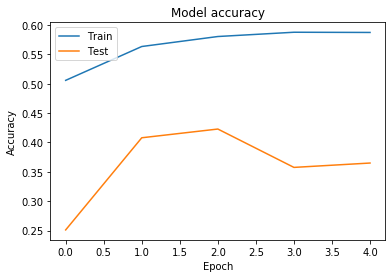

In [47]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

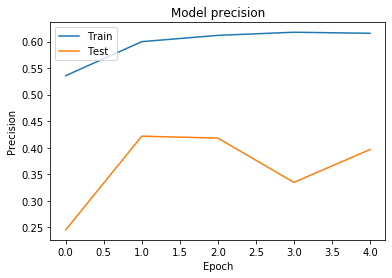

In [48]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

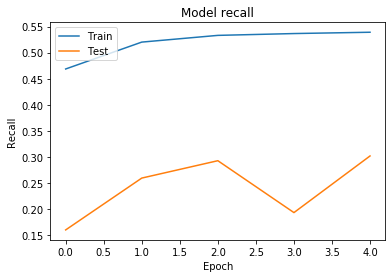

In [49]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

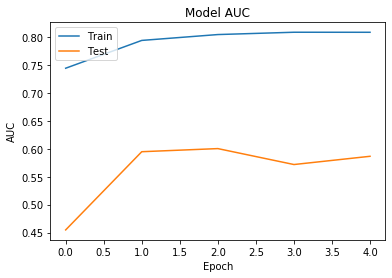

In [50]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()